<a href="https://colab.research.google.com/github/BI-DS/EBA-3530/blob/master/lecture8/tfp_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tutorial: Introduction to TensorFlow Probability (TFP)
## Modeling a Unimodal Gaussian Distribution

**TensorFlow Probability (TFP)** is a library built on top of TensorFlow that makes it easy to combine probabilistic models with deep learning.

In this notebook, we will explore the `tfp.distributions` layer (often aliased as `tfd`). We will focus on the simplest building block: the **Unimodal Gaussian (Normal) Distribution**.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
import seaborn as sns

# Common aliases
tfd = tfp.distributions

print("TensorFlow version:", tf.__version__)
print("TensorFlow Probability version:", tfp.__version__)

# Set visualization style
sns.set_style("whitegrid")

TensorFlow version: 2.19.0
TensorFlow Probability version: 0.25.0


### 1. Defining a Distribution

In TFP, distributions are objects. We can create a Gaussian distribution by specifying its mean (`loc`) and standard deviation (`scale`).

Let's create a standard normal distribution $\mathcal{N}(\mu=0, \sigma=1)$.

In [2]:
# Create a Normal distribution object
# loc = mean, scale = standard deviation
normal_dist = tfd.Normal(loc=0., scale=1.)

print(normal_dist)

tfp.distributions.Normal("Normal", batch_shape=[], event_shape=[], dtype=float32)


We can easily get parameters and draw random variables

In [27]:
print('The expectation of the distribution is {:.1f}'.format(normal_dist.mean().numpy()))
print('The stardard deviation of the distribution is {:.1f}'.format(normal_dist.stddev().numpy()))
print('This is random variable from the distribution {:.2f}'.format(normal_dist.sample().numpy()))

The expectation of the distribution is 0.0
The stardard deviation of the distribution is 1.0
This is random variable from the distribution 0.09


### 2. Sampling and Visualization

Once we have a distribution object, we can perform two main operations:
1.  **Sampling:** Generating random numbers from the distribution.
2.  **Log Probability:** Calculating how likely a given value is under the distribution.

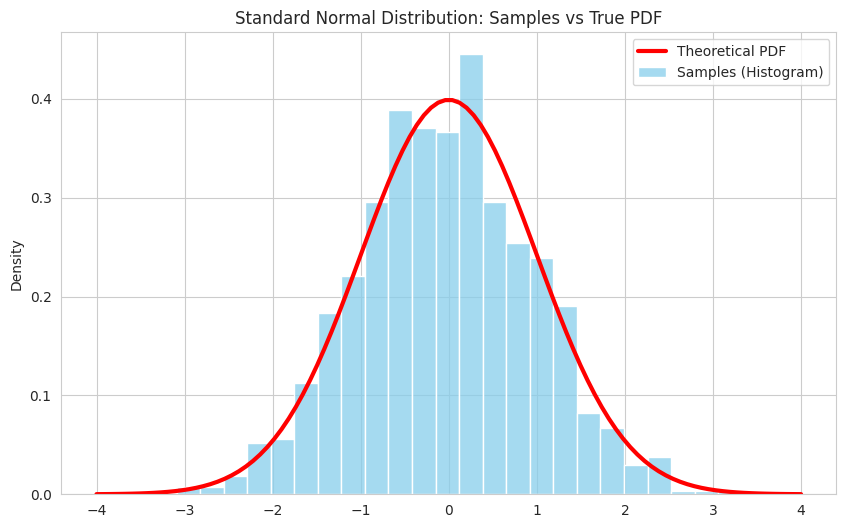

In [3]:
# Sample 1000 data points from our standard normal distribution
samples = normal_dist.sample(1000)

# Evaluate the PDF at x (for plotting theory)
x_values = np.linspace(-4, 4, 100)
log_pdf_values = normal_dist.log_prob(x_values)
pdf_values = tf.exp(log_pdf_values)

# Visualizing the distribution
plt.figure(figsize=(10, 6))

# Plot histogram of samples
sns.histplot(samples, kde=False, stat="density", label="Samples (Histogram)", color="skyblue")

# Plot the theoretical PDF
plt.plot(x_values, pdf_values, 'r-', lw=3, label="Theoretical PDF")

plt.title("Standard Normal Distribution: Samples vs True PDF")
plt.legend()
plt.show()

### 3. Maximum Likelihood Estimation (MLE)

This is where TFP shines. We can use TensorFlow's optimization tools to **learn** the parameters of a distribution from data.

**The Scenario:** Imagine we observed some data `observed_data` (generated below), but we don't know the mean or standard deviation that produced it. We want to find the best $\mu$ and $\sigma$.

In [23]:
# --- A. Generate Data ---

# True parameters (hidden from our model)
TRUE_MEAN = 5.0
TRUE_STD = 2.0

# Generate 200 observations
obs_dist = tfd.Normal(loc=TRUE_MEAN, scale=TRUE_STD)
observed_data = obs_dist.sample(200)

print(f"Observed data mean: {tf.reduce_mean(observed_data):.2f}")

Observed data mean: 5.11


We define two variables for the parameters we want to learn.
* `mu`: The mean (can be any real number).
* `sigma_param`: The parameter controlling standard deviation. *Note: We use a softplus transformation later to ensure the standard deviation is always positive.*

In [17]:
# --- B. Define Variables ---

# Initialize guesses (e.g., guessing mean=0, std=1)
mu_var = tf.Variable(0.0, name="mean")
sigma_param_var = tf.Variable(0.0, name="sigma_param")

# --- C. Define Loss (Negative Log Likelihood) ---

def nll_loss():
    # 1. Transform the raw variable to a positive scale for Std Dev
    current_sigma = tf.math.softplus(sigma_param_var)

    # 2. Define the distribution using current estimates
    current_dist = tfd.Normal(loc=mu_var, scale=current_sigma)

    # 3. Calculate log_prob of the OBSERVED data
    log_probs = current_dist.log_prob(observed_data)

    # 4. Sum them up and negate (to minimize)
    return -tf.reduce_sum(log_probs)

In [18]:
@tf.function
def minimize(loss_fn, var_list, optimizer):
    with tf.GradientTape() as tape:
        loss = loss_fn()
    grads = tape.gradient(loss, var_list)
    optimizer.apply_gradients(zip(grads, var_list))
    return loss

Now we run the training loop using the Adam optimizer.

In [19]:
# --- D. Optimization Loop ---
optimizer = tf.optimizers.Adam(learning_rate=0.1)

print("--- Starting Optimization ---")

for i in range(300):

    # SIMPLE ONE-LINER (Using our helper)
    current_loss = minimize(nll_loss, [mu_var, sigma_param_var], optimizer)

    if i % 20 == 0:
        print(f"Step {i}: Loss={current_loss:.1f}")

print("\n--- Optimization Finished ---")
print(f"True Mean: {TRUE_MEAN} | Learned Mean: {mu_var.numpy():.2f}")
print(f"True Std:  {TRUE_STD} | Learned Std:  {tf.math.softplus(sigma_param_var).numpy():.2f}")

--- Starting Optimization ---
Step 0: Loss=6268.5
Step 20: Loss=850.4
Step 40: Loss=580.6
Step 60: Loss=517.6
Step 80: Loss=486.4
Step 100: Loss=466.2
Step 120: Loss=452.0
Step 140: Loss=441.8
Step 160: Loss=434.4
Step 180: Loss=429.0
Step 200: Loss=425.2
Step 220: Loss=422.4
Step 240: Loss=420.5
Step 260: Loss=419.1
Step 280: Loss=418.1

--- Optimization Finished ---
True Mean: 5.0 | Learned Mean: 5.01
True Std:  2.0 | Learned Std:  2.12


### 4. Final Visualization
Let's see if the learned distribution matches the data.

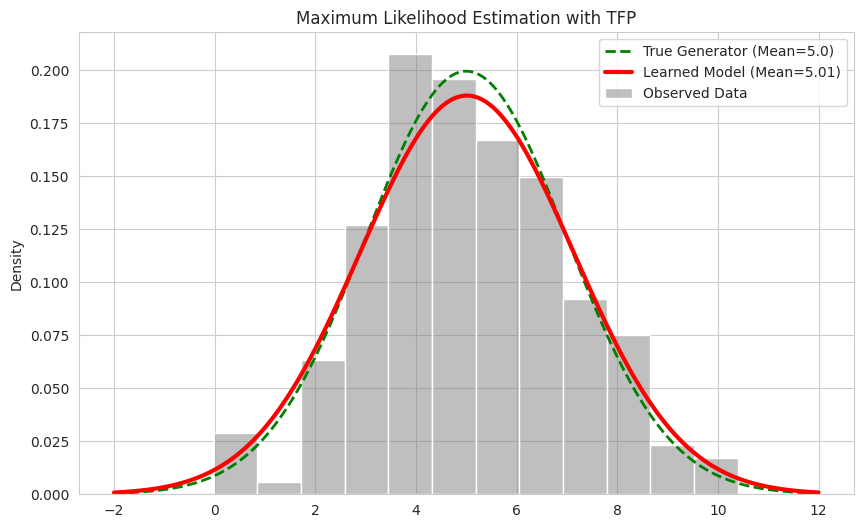

In [24]:
final_mu = mu_var.numpy()
final_std = tf.math.softplus(sigma_param_var).numpy()

# Create the learned distribution
learned_dist = tfd.Normal(loc=final_mu, scale=final_std)

# Plotting
plt.figure(figsize=(10, 6))

# 1. The Data
sns.histplot(observed_data, kde=False, stat="density", label="Observed Data", color="gray", alpha=0.5)

# 2. The True Generator (Green dashed)
x_range = np.linspace(-2, 12, 200)
plt.plot(x_range, obs_dist.prob(x_range), 'g--', lw=2, label=f"True Generator (Mean={TRUE_MEAN})")

# 3. The Learned Model (Red solid)
plt.plot(x_range, learned_dist.prob(x_range), 'r-', lw=3, label=f"Learned Model (Mean={final_mu:.2f})")

plt.legend()
plt.title("Maximum Likelihood Estimation with TFP")
plt.show()